In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [3]:
# Main dataset path (Part A)
data_path = '/content/drive/MyDrive/DNN/Datasets/ShanghaiTech/part_A'

# Training set
train_img_dir = os.path.join(data_path, 'train_data', 'images')
train_gt_dir  = os.path.join(data_path, 'train_data', 'ground_truth')

# Testing set
test_img_dir = os.path.join(data_path, 'test_data', 'images')
test_gt_dir  = os.path.join(data_path, 'test_data', 'ground_truth')

train_images = sorted(os.listdir(train_img_dir))
train_gts = sorted(os.listdir(train_gt_dir))

print("📂 Sorted example train image:", train_images[15])
print("📂 Sorted example train GT:", train_gts[15])


📂 Sorted example train image: IMG_112.jpg
📂 Sorted example train GT: GT_IMG_112.mat


# Load Images

In [4]:
from scipy.io import loadmat

def load_shanghaitech_partA(image_dir, gt_dir, img_size=(256, 256)):
    images = []
    points_list = []

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        mat_path = os.path.join(gt_dir, 'GT_' + img_name.replace('.jpg', '.mat'))

        # Load and resize image
        img = cv2.imread(img_path)
        original_shape = img.shape[:2]  # (H, W)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0

        # Load head annotations
        mat = loadmat(mat_path)
        points = mat['image_info'][0][0][0][0][0]  # shape: (N, 2)

        # Scale annotations to resized image
        scale_y = img_size[0] / original_shape[0]
        scale_x = img_size[1] / original_shape[1]
        points_rescaled = points.copy()
        points_rescaled[:, 0] *= scale_x  # x-coord
        points_rescaled[:, 1] *= scale_y  # y-coord

        images.append(img)
        points_list.append(points_rescaled)

    return images, points_list

# Load train and test data
train_images, train_annotations = load_shanghaitech_partA(train_img_dir, train_gt_dir, img_size=(256, 256))
test_images, test_annotations = load_shanghaitech_partA(test_img_dir, test_gt_dir, img_size=(256, 256))

# ✅ Print dataset info
print("✅ Successfully fetched all data!")

print("───────────────────────────────────")
print(f"📁 Training Set:")
print(f"  - Images:      {len(train_images)}")
print(f"  - Annotations: {len(train_annotations)}")
print(f"  - Image shape: {train_images[0].shape}")
print(f"  - Annotation shape: {train_annotations[0].shape}")

print("\n📁 Testing Set:")
print(f"  - Images:      {len(test_images)}")
print(f"  - Annotations: {len(test_annotations)}")
print(f"  - Image shape: {test_images[0].shape}")
print(f"  - Annotation shape: {test_annotations[0].shape}")


✅ Successfully fetched all data!
───────────────────────────────────
📁 Training Set:
  - Images:      300
  - Annotations: 300
  - Image shape: (256, 256, 3)
  - Annotation shape: (1546, 2)

📁 Testing Set:
  - Images:      182
  - Annotations: 182
  - Image shape: (256, 256, 3)
  - Annotation shape: (172, 2)


# Generate Ground Truth Density Map

In [16]:
from scipy.ndimage import gaussian_filter
import cv2
import numpy as np

from scipy.spatial import KDTree

def generate_adaptive_density_map(image_shape, points, beta=0.3, k=3):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density_map

    tree = KDTree(points, leafsize=2048)
    distances, _ = tree.query(points, k=min(k+1, len(points)))

    for i, point in enumerate(points):
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))

        if len(points) > k:
            sigma = beta * np.mean(distances[i][1:])
        else:
            sigma = 4  # fallback

        density_map[y, x] += 1
        density_map = gaussian_filter(density_map, sigma=sigma)

    return density_map


# 1️⃣ Generate full-resolution density maps
train_density = [generate_adaptive_density_map((256, 256), pts) for pts in train_annotations]
test_density  = [generate_adaptive_density_map((256, 256), pts) for pts in test_annotations]

# 2️⃣ Resize to 64x64 and adjust count scaling
train_density_resized = [cv2.resize(dm, (64, 64), interpolation=cv2.INTER_CUBIC) for dm in train_density]
test_density_resized  = [cv2.resize(dm, (64, 64), interpolation=cv2.INTER_CUBIC) for dm in test_density]

# Scale density values to preserve total count
scaling_factor = (256 * 256) / (64 * 64)  # = 16
train_density_resized = [dm * scaling_factor for dm in train_density_resized]
test_density_resized  = [dm * scaling_factor for dm in test_density_resized]

# 3️⃣ Final reshape
X_train = np.array(train_images, dtype=np.float32)
Y_train = np.expand_dims(np.array(train_density_resized), axis=-1)

X_test = np.array(test_images, dtype=np.float32)
Y_test = np.expand_dims(np.array(test_density_resized), axis=-1)


# Visualize Ground Truth + Density Map

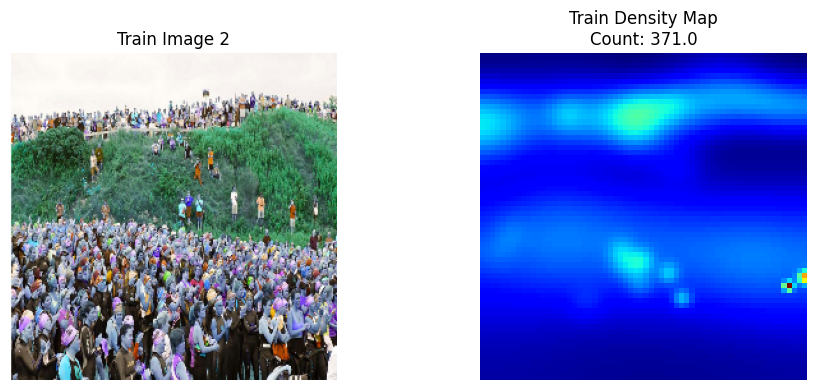

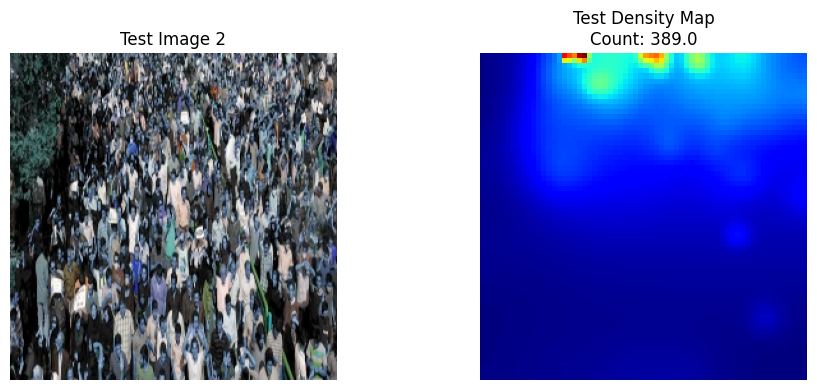

In [17]:
import matplotlib.pyplot as plt

def plot_image_and_density(X, Y, index, title_prefix="Train"):
    image = X[index]
    density_map = Y[index].squeeze()

    plt.figure(figsize=(10, 4))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"{title_prefix} Image {index}")
    plt.axis('off')

    # Show density map
    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title(f"{title_prefix} Density Map\nCount: {np.sum(density_map):.1f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show training sample
plot_image_and_density(X_train, Y_train, index=2, title_prefix="Train")

# Show testing sample
plot_image_and_density(X_test, Y_test, index=2, title_prefix="Test")

# MCNN Model

In [18]:
from tensorflow.keras import layers, Model, Input

def MCNN(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Branch 1: Large receptive field
    b1 = layers.Conv2D(16, (9, 9), padding='same', activation='relu')(inputs)
    b1 = layers.MaxPooling2D((2, 2))(b1)
    b1 = layers.Conv2D(32, (7, 7), padding='same', activation='relu')(b1)
    b1 = layers.MaxPooling2D((2, 2))(b1)
    b1 = layers.Conv2D(16, (7, 7), padding='same', activation='relu')(b1)
    b1 = layers.Conv2D(8, (7, 7), padding='same', activation='relu')(b1)

    # Branch 2: Medium receptive field
    b2 = layers.Conv2D(20, (7, 7), padding='same', activation='relu')(inputs)
    b2 = layers.MaxPooling2D((2, 2))(b2)
    b2 = layers.Conv2D(40, (5, 5), padding='same', activation='relu')(b2)
    b2 = layers.MaxPooling2D((2, 2))(b2)
    b2 = layers.Conv2D(20, (5, 5), padding='same', activation='relu')(b2)
    b2 = layers.Conv2D(10, (5, 5), padding='same', activation='relu')(b2)

    # Branch 3: Small receptive field
    b3 = layers.Conv2D(24, (5, 5), padding='same', activation='relu')(inputs)
    b3 = layers.MaxPooling2D((2, 2))(b3)
    b3 = layers.Conv2D(48, (3, 3), padding='same', activation='relu')(b3)
    b3 = layers.MaxPooling2D((2, 2))(b3)
    b3 = layers.Conv2D(24, (3, 3), padding='same', activation='relu')(b3)
    b3 = layers.Conv2D(12, (3, 3), padding='same', activation='relu')(b3)

    # Concatenate outputs from all 3 branches
    merged = layers.Concatenate()([b1, b2, b3])

    # Final output: single-channel density map
    output = layers.Conv2D(1, (1, 1), padding='same', activation='linear')(merged)

    model = Model(inputs=inputs, outputs=output)
    return model


# Compile and Train

In [19]:
model = MCNN()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

mae_per_epoch = []
rmse_per_epoch = []

epochs = 20

for epoch in range(epochs):
    print(f"\n🔁 Epoch {epoch + 1}/{epochs}")
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1, batch_size=4, verbose=1)

    # Predict on test set after this epoch
    Y_pred = model.predict(X_test)
    Y_pred[Y_pred < 0] = 0  # clip negatives

    # Evaluate MAE & RMSE
    gt_counts = [np.sum(gt) for gt in Y_test]
    pred_counts = [np.sum(pred) for pred in Y_pred]

    mae = np.mean([abs(g - p) for g, p in zip(gt_counts, pred_counts)])
    rmse = np.sqrt(np.mean([(g - p) ** 2 for g, p in zip(gt_counts, pred_counts)]))

    mae_per_epoch.append(mae)
    rmse_per_epoch.append(rmse)

    print(f"📉 MAE: {mae:.2f}, RMSE: {rmse:.2f}")



🔁 Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 0.0493 - mae: 0.1288 - val_loss: 0.0253 - val_mae: 0.0850
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
📉 MAE: 237.11, RMSE: 324.47

🔁 Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0457 - mae: 0.1094 - val_loss: 0.0285 - val_mae: 0.0756
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
📉 MAE: 230.07, RMSE: 371.68

🔁 Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0485 - mae: 0.1139 - val_loss: 0.0256 - val_mae: 0.1011
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
📉 MAE: 310.72, RMSE: 375.99

🔁 Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0381 - mae: 0.1044 - val_loss: 0.0283 - val_mae: 0.0779
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
📉 MAE: 230.11, RMSE: 374.91

🔁 Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0515 - mae: 0.1213 - val_loss: 0.0218 - val_mae: 0.0710
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
📉 MAE: 195.01, RMSE: 290.21

🔁 Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0453

# Visualize Predictions

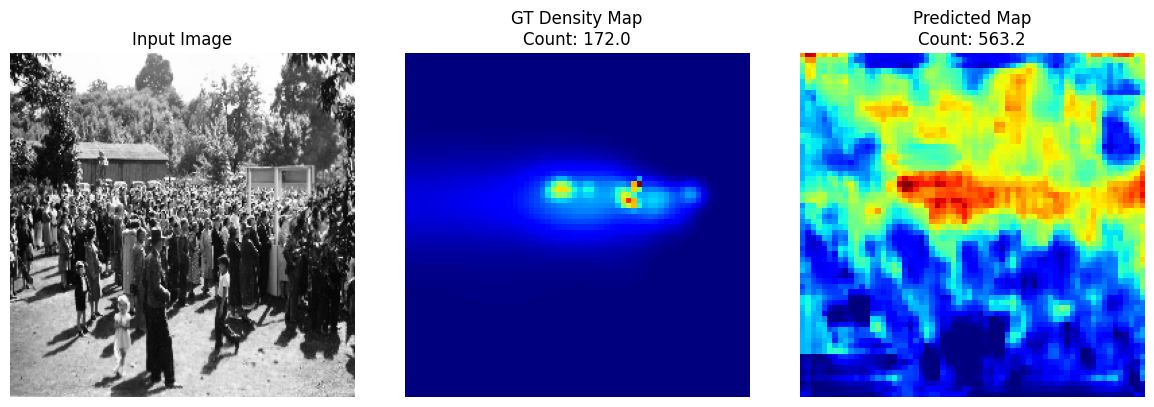

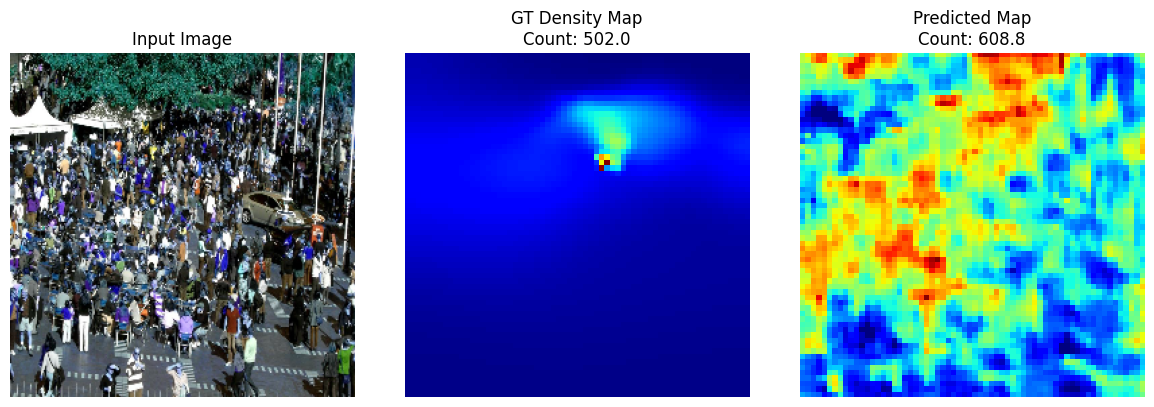

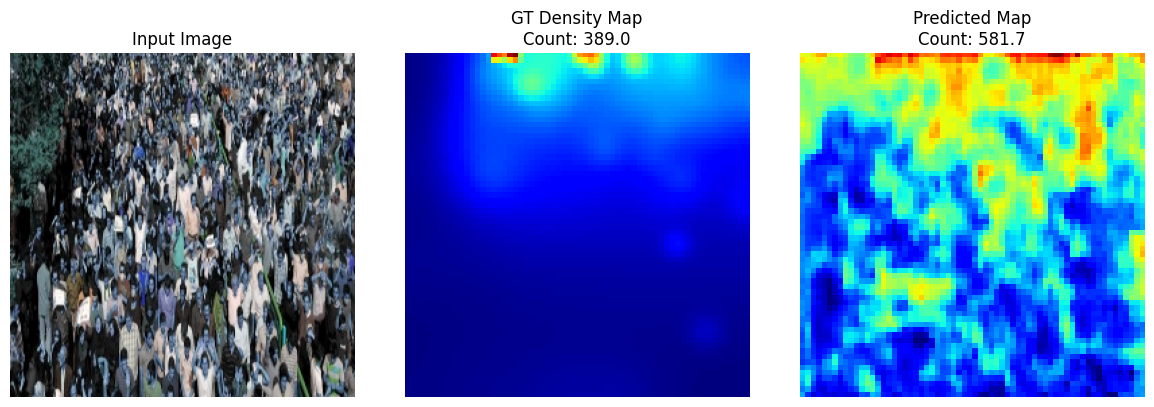

In [20]:
import matplotlib.pyplot as plt

def visualize_prediction(index):
    image = X_test[index]
    gt_map = Y_test[index].squeeze()
    pred_map = Y_pred[index].squeeze()

    gt_count = np.sum(gt_map)
    pred_count = np.sum(pred_map)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_map, cmap='jet')
    plt.title(f"GT Density Map\nCount: {gt_count:.1f}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_map, cmap='jet')
    plt.title(f"Predicted Map\nCount: {pred_count:.1f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show 3 predictions
for i in range(3):
    visualize_prediction(i)


# Plot MAE vs Epoch and RMSE vs Epoch

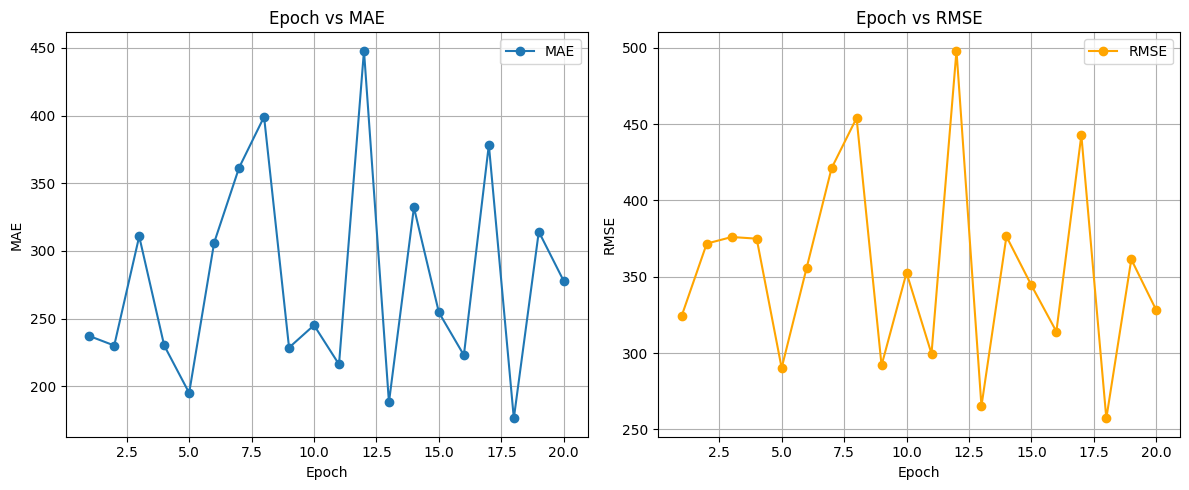

In [21]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(mae_per_epoch) + 1)

plt.figure(figsize=(12, 5))

# MAE Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae_per_epoch, marker='o', label='MAE')
plt.title("Epoch vs MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()

# RMSE Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, rmse_per_epoch, marker='o', label='RMSE', color='orange')
plt.title("Epoch vs RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()